# 🚀 Analyzing the Indian VC Landscape: Trends, Top Players, and Investment Networks

---

## 🎯 **Project Goal**

To analyze a real-world dataset of venture capital (VC) funding in India to:

- 🔍 Identify **key investment trends** across years
- 🏭 Discover **top-performing industry verticals**
- 💸 Highlight **top investors** and their funding patterns
- 📍 Locate major **startup hubs** geographically
- 🤝 Uncover **co-investment networks** between investors
- 🧠 Develop a simple **investor recommendation tool** based on sector and funding stage

---

## 📦 Dataset Source
*Extracted from Quadratic AI – contains details about funding amounts, investors, industries, and deal dates across multiple Indian startups.*

---

## 📈 Why This Project?
India's startup ecosystem is growing rapidly, and understanding VC behavior helps:

- Founders find the right investors
- Analysts discover market gaps
- VCs track peer activity and trends

> _"Investments are data-rich stories. Let's decode the venture capital narrative behind India’s innovation boom."_

---


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import defaultdict
import re

In [6]:
# Load the dataset
df = pd.read_csv('VC_Investment_Data_Generator.csv')

# --- Data Cleaning ---
# Drop unnecessary columns
df = df.drop(columns=['Seed Companies', 'Partners'])

# Remove duplicate rows
df = df.drop_duplicates()

# Clean the 'Amount' column
def clean_amount(amount):
    if isinstance(amount, str):
        amount = amount.replace('$', '').replace('+', '').replace(',', '').strip()
        if 'B' in amount:
            return float(amount.replace('B', '')) * 1000
        elif 'M' in amount:
            return float(amount.replace('M', ''))
    return amount

df['Amount_USD_M'] = df['Amount'].apply(clean_amount)

# Clean the 'Date' column
def clean_date(date):
    if isinstance(date, str):
        date = date.strip()
        if re.fullmatch(r'\d{4}', date):
            return pd.to_datetime(date, format='%Y')
        elif re.fullmatch(r'\d{1,2}-\d{1,2}-\d{4}', date):
            return pd.to_datetime(date, format='%d-%m-%Y')
        elif re.fullmatch(r'\d{4}-Q[1-4]', date):
            year, quarter = date.split('-Q')
            month = (int(quarter) - 1) * 3 + 1
            return pd.to_datetime(f'{year}-{month}-01')
        elif re.fullmatch(r'\d{4}-H[1-2]', date):
            year, half = date.split('-H')
            month = (int(half) - 1) * 6 + 1
            return pd.to_datetime(f'{year}-{month}-01')
    return pd.NaT

df['Cleaned_Date'] = df['Date'].apply(clean_date)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24924\2058603642.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_industries.values, y=top_industries.index, palette='viridis')


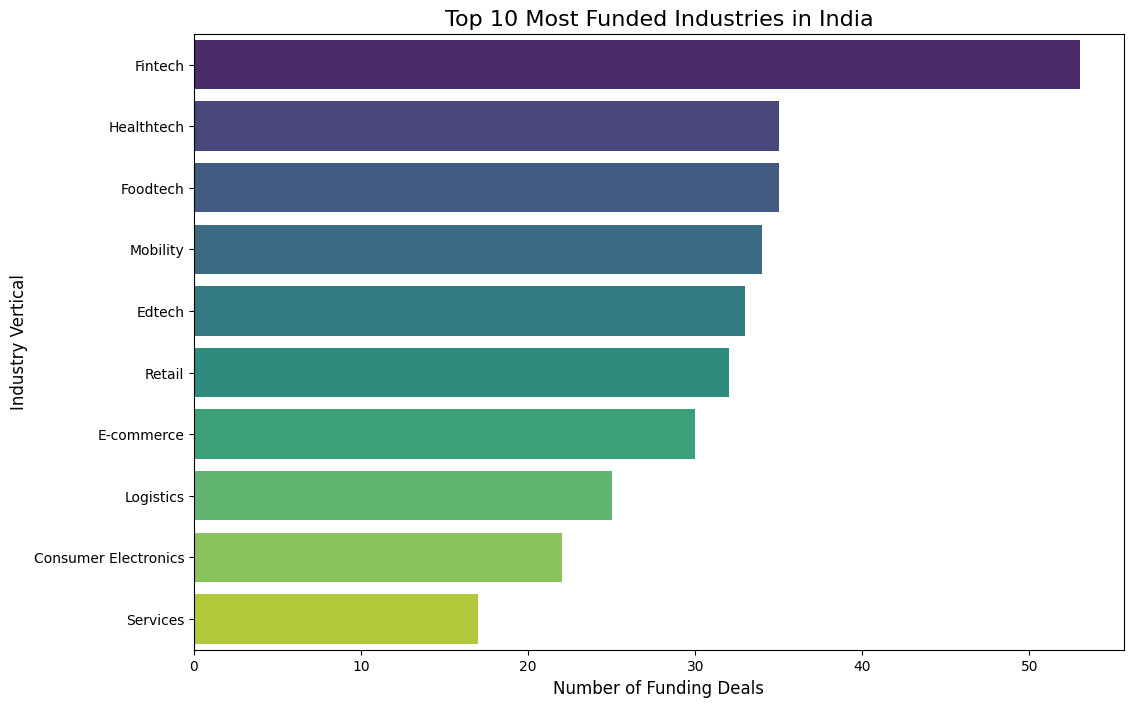

In [7]:
plt.figure(figsize=(12, 8))
top_industries = df['Industry Vertical'].value_counts().head(10)
sns.barplot(x=top_industries.values, y=top_industries.index, palette='viridis')
plt.title('Top 10 Most Funded Industries in India', fontsize=16)
plt.xlabel('Number of Funding Deals', fontsize=12)
plt.ylabel('Industry Vertical', fontsize=12)
plt.savefig('top_industries.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24924\2644958276.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.values, y=top_cities.index, palette='plasma')


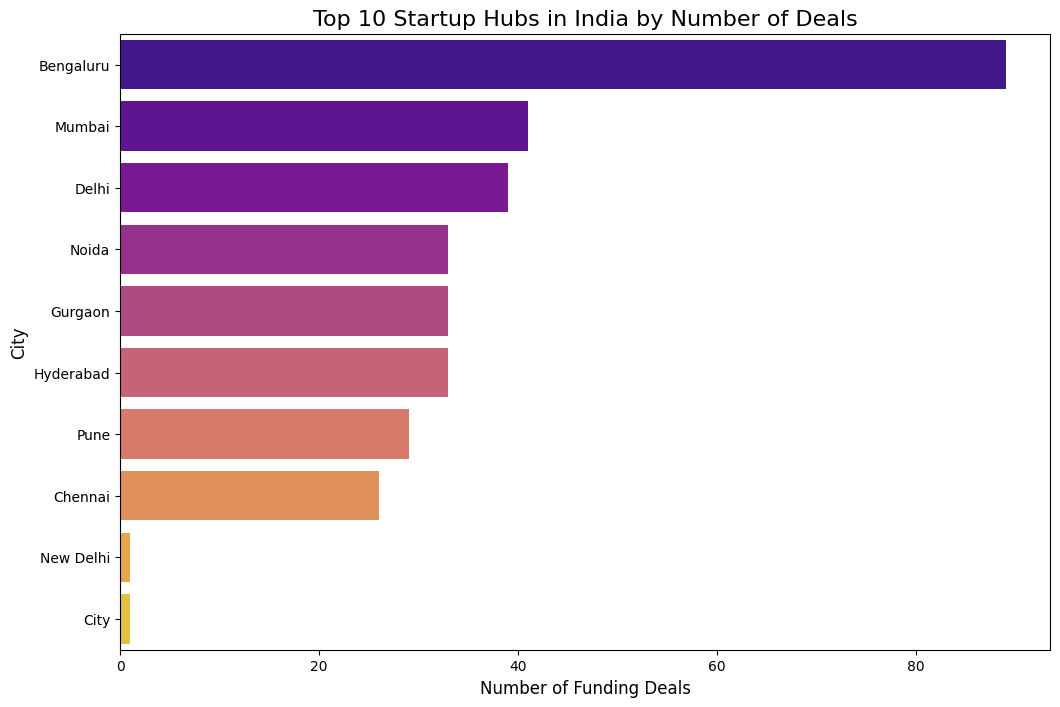

In [8]:
plt.figure(figsize=(12, 8))
top_cities = df['City'].value_counts().head(10)
sns.barplot(x=top_cities.values, y=top_cities.index, palette='plasma')
plt.title('Top 10 Startup Hubs in India by Number of Deals', fontsize=16)
plt.xlabel('Number of Funding Deals', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.savefig('top_cities.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24924\199082226.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_funding = df_time.set_index('Cleaned_Date')['Amount_USD_M'].resample('M').sum()


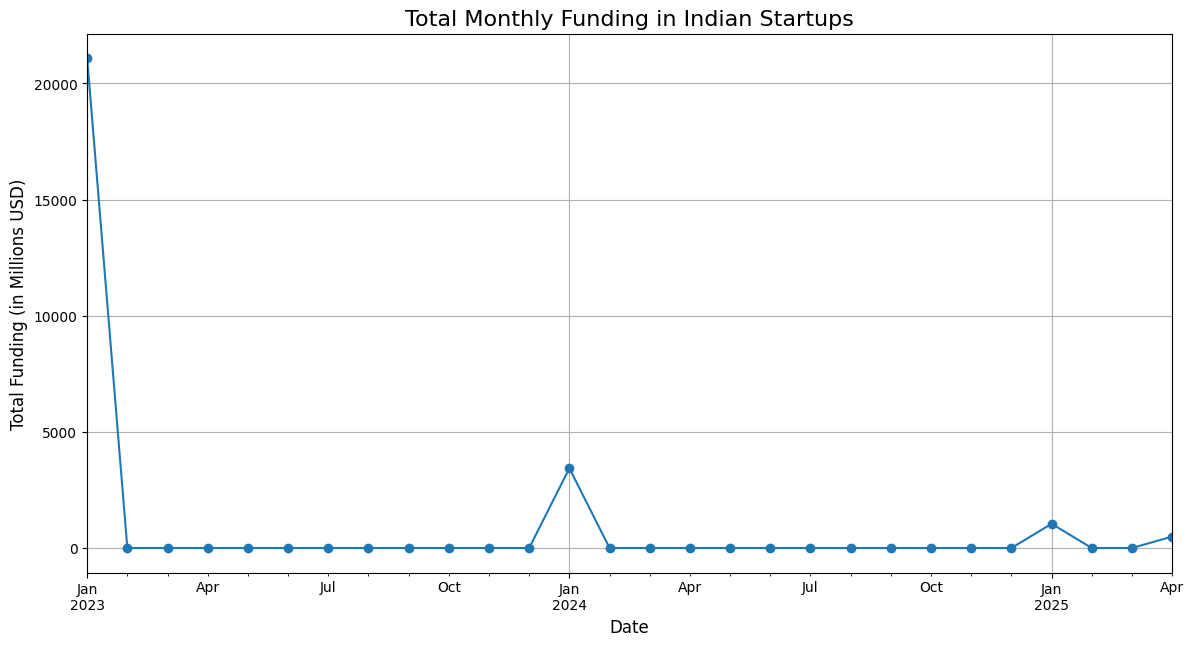

In [9]:
# Monthly Funding Trends
df_time = df.dropna(subset=['Cleaned_Date', 'Amount_USD_M'])
monthly_funding = df_time.set_index('Cleaned_Date')['Amount_USD_M'].resample('M').sum()
plt.figure(figsize=(14, 7))
monthly_funding.plot(kind='line', marker='o')
plt.title('Total Monthly Funding in Indian Startups', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Funding (in Millions USD)', fontsize=12)
plt.grid(True)
plt.savefig('monthly_funding_trends.png', dpi=300, bbox_inches='tight')
plt.show()

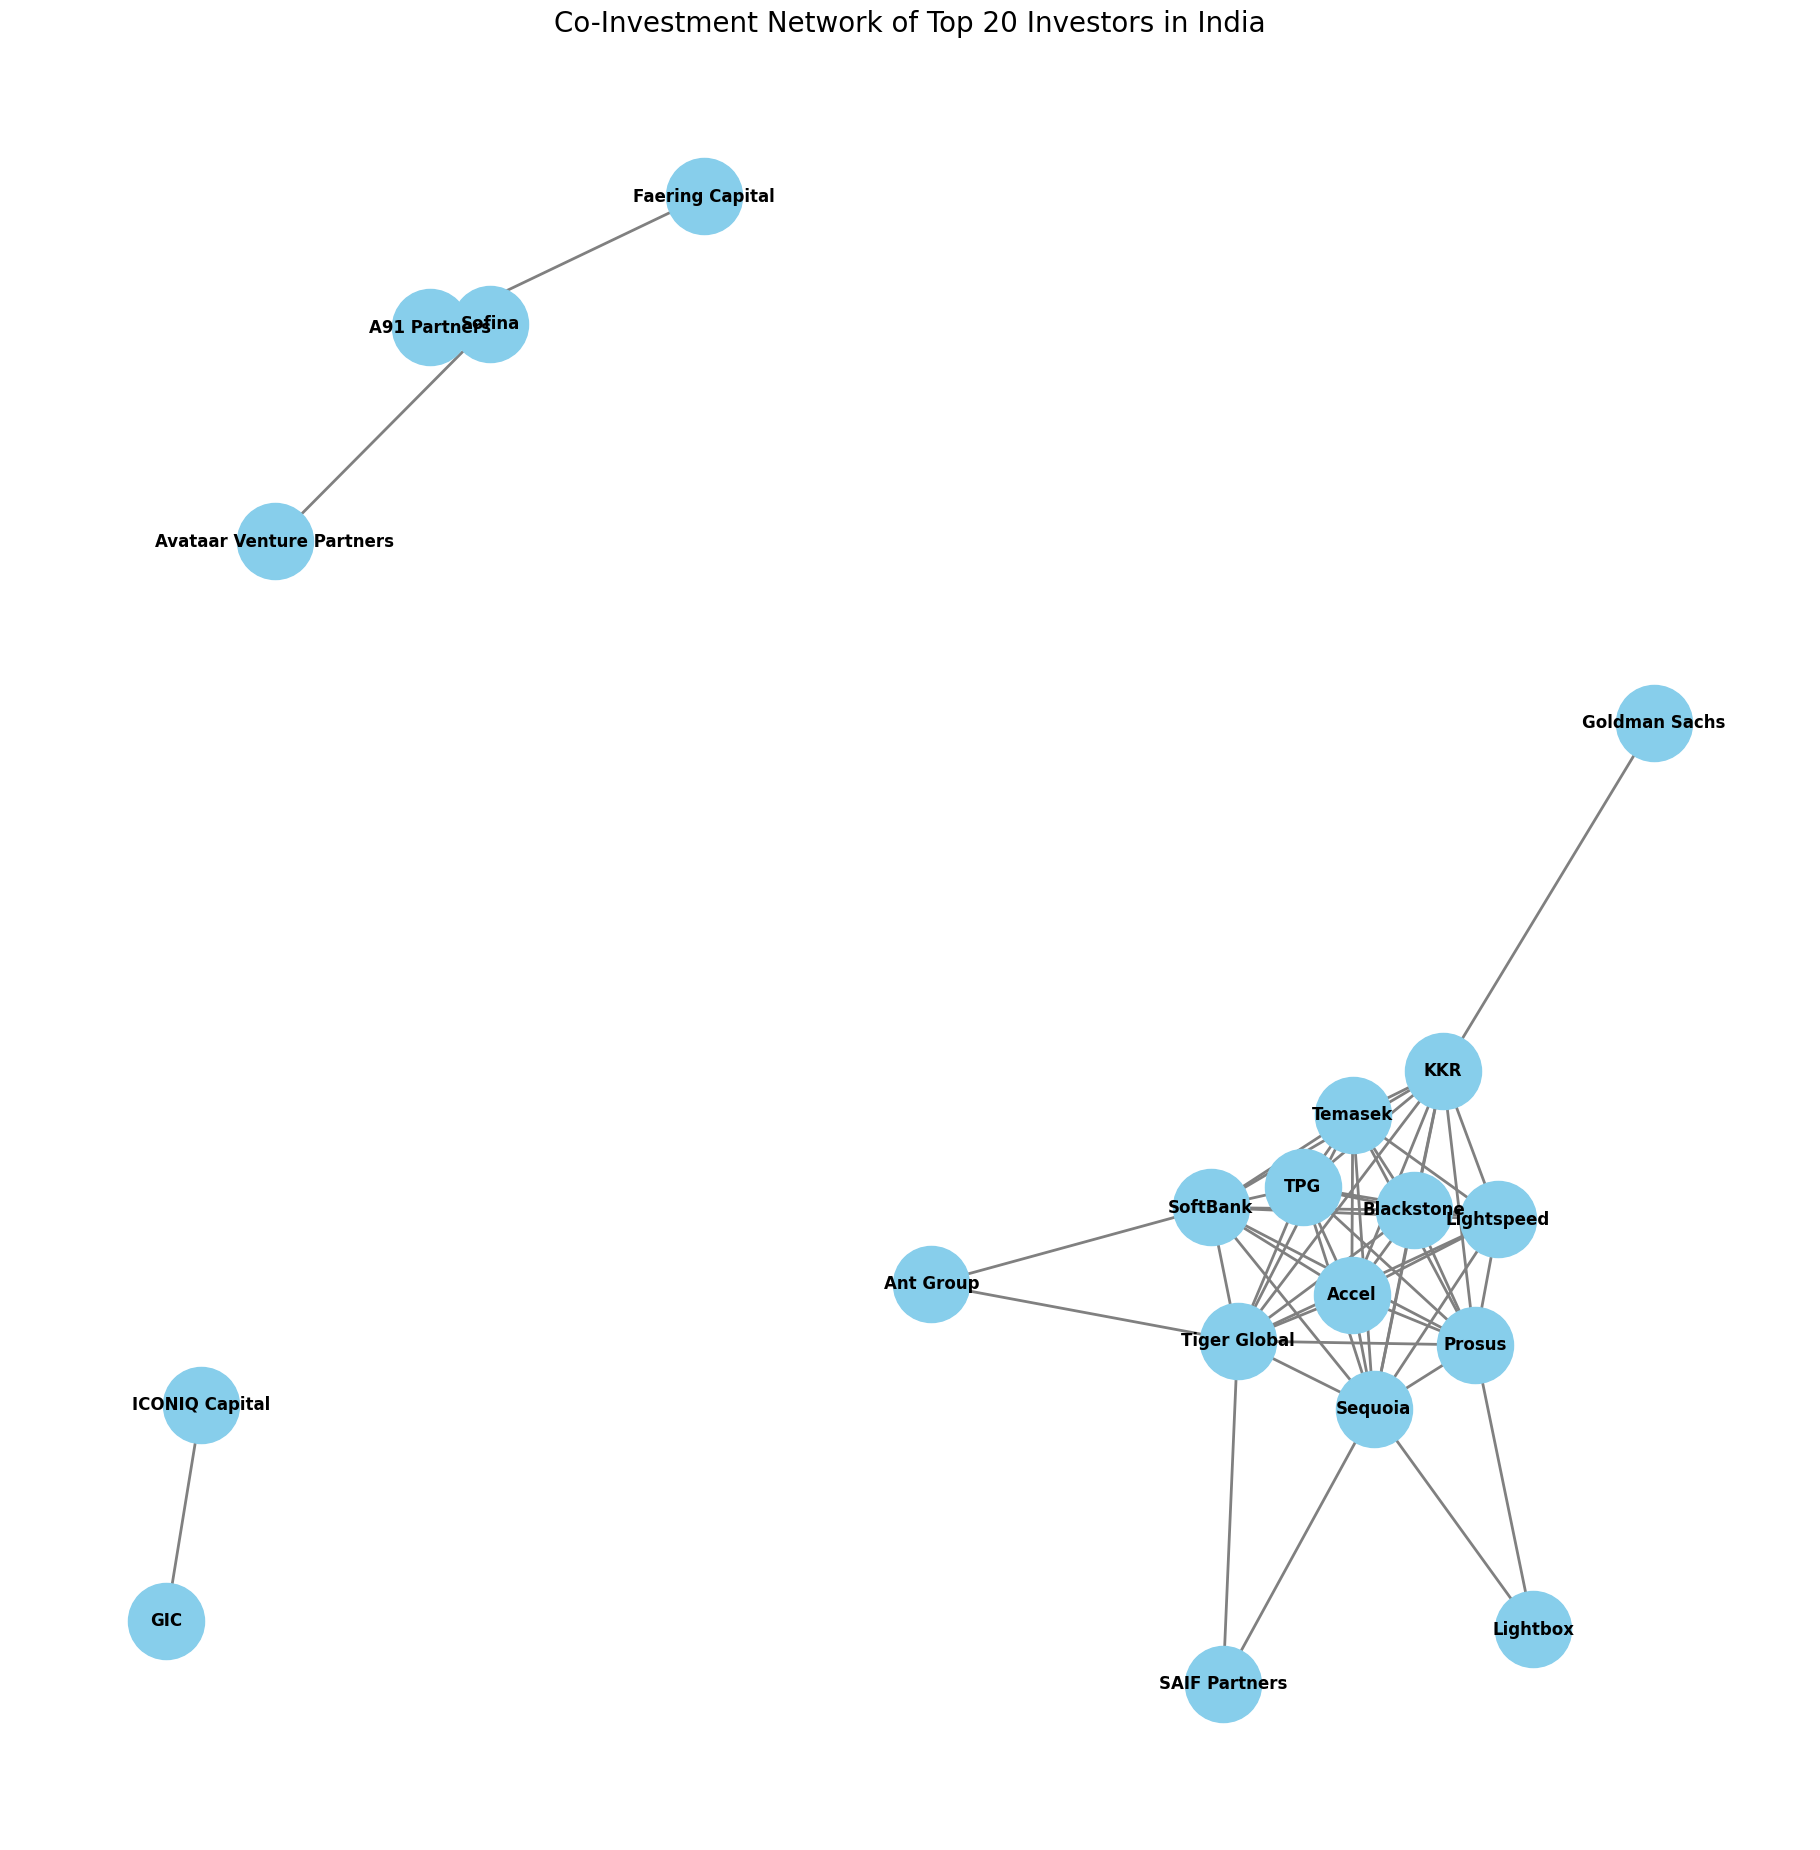

In [10]:
df['Investors_list'] = df['Investors'].str.split(', ')
investor_pairs = []
for investors_list in df['Investors_list'].dropna():
    investors = sorted([inv.strip() for inv in investors_list])
    for i in range(len(investors)):
        for j in range(i + 1, len(investors)):
            investor_pairs.append((investors[i], investors[j]))

# Create a graph from the investor pairs
G = nx.Graph()
G.add_edges_from(investor_pairs)

# Get the top 20 investors by number of connections
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:20]
top_investors_graph = G.subgraph([node for node, degree in top_nodes])

# Visualize the network
plt.figure(figsize=(18, 18))
pos = nx.spring_layout(top_investors_graph, k=0.6, iterations=50)
nx.draw(top_investors_graph, pos, with_labels=True, node_size=3000,
        node_color='skyblue', font_size=12, font_weight='bold',
        width=2, edge_color='gray')
plt.title('Co-Investment Network of Top 20 Investors in India', fontsize=20)
plt.savefig('investor_network.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
industry_investors = defaultdict(list)
for index, row in df.iterrows():
    industry = row['Industry Vertical']
    investors = row['Investors_list']
    if isinstance(investors, list):
        industry_investors[industry].extend(investors)

def recommend_investors(industry, top_n=5):
    """Recommends top investors for a given industry based on their investment frequency."""
    if industry not in industry_investors:
        return f"No data available for the '{industry}' industry."

    investor_counts = pd.Series(industry_investors[industry]).value_counts()
    top_investors = investor_counts.head(top_n)

    print(f"\nTop {top_n} recommended investors for the '{industry}' industry:")
    return top_investors

# Example Usage:
print("\n--- Investor Recommendation Tool ---")
recommendations_fintech = recommend_investors('Fintech')
print(recommendations_fintech)

recommendations_healthtech = recommend_investors('Healthtech')
print(recommendations_healthtech)


--- Investor Recommendation Tool ---

Top 5 recommended investors for the 'Fintech' industry:
Sequoia         16
Tiger Global    16
Temasek         12
SoftBank         9
Accel            8
Name: count, dtype: int64

Top 5 recommended investors for the 'Healthtech' industry:
Tiger Global    11
Sequoia          8
SoftBank         7
KKR              7
Temasek          7
Name: count, dtype: int64


# ✅ Conclusion & Key Takeaways

---

This project explored the **Indian Venture Capital (VC) landscape** using real-world investment data and produced several valuable insights for entrepreneurs, analysts, and investors:

---

### 🔍 Key Insights

1. 🏦 **Top Industries**  
   **Fintech**, **Foodtech**, and **Healthtech** emerged as the **most funded sectors**, showing strong investor confidence and continued growth potential.

2. 📍 **Startup Hubs**  
   **Bengaluru** and **Mumbai** stand out as **epicenters of startup activity**, driven by talent density, investor access, and supportive ecosystems.

3. 🤝 **Investor Network**  
   The **investment network** is closely interconnected. Leading players like **Tiger Global**, **Sequoia Capital**, and **Accel** often **co-invest**, forming a backbone of the Indian VC ecosystem.

4. 🧠 **Practical Application**  
   A **recommendation tool** was developed to help **startup founders** find suitable investors based on their domain and funding stage—offering a data-driven approach to strategic fundraising.

---

> _"VC investments are more than capital — they’re signals of where innovation is heading."_

📊 Next steps could include integrating real-time VC feeds or extending the tool into a live dashboard.

---

